In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed, Attention, AdditiveAttention
! pip install googletrans==4.0.0rc1
from googletrans import Translator
from keras.preprocessing.text import one_hot, Tokenizer
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import pickle as pkl
import numpy as np
import tensorflow as tf

In [ ]:
from itertools import chain
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_doc(filename):
	file = open(filename, mode='rt', encoding='utf-8')
	text = file.read()
	file.close()
	return text

In [ ]:
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

In [ ]:
def clean_pairs(lines):
	cleaned = list()
	re_punc = re.compile('[।%s]' % re.escape(string.punctuation))
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	for pair in lines:
		clean_pair = list()
		for line in pair:
			line = line.split()
			line = [re_punc.sub('', w) for w in line]
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return np.array(cleaned)

In [ ]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	pkl.dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

In [ ]:
def predict__sentences(sentence):
  trs=Translator()
  result=trs.translate(sentence, dest='hi').text
  return result

In [ ]:
filename = '/content/drive/MyDrive/eng-hin.txt'
doc = load_doc(filename)
pairs = to_pairs(doc)
clean_pairs = clean_pairs(pairs)
print ("Number of clean pairs",clean_pairs.shape[0])
save_clean_data(clean_pairs, '/content/drive/MyDrive/english-hindi.pkl')

In [ ]:
def load_clean_sentences(filename):
	return pkl.load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	pkl.dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('/content/drive/MyDrive/english-hindi.pkl')

# reduce dataset size
#n_sentences = raw_dataset.shape[0]
dataset = raw_dataset[:40000,]
print (len(dataset))
# random shuffle
shuffle(dataset)
# save
save_clean_data(dataset, '/content/drive/MyDrive/english-hindi-both.pkl')

In [ ]:
dataset_list=(list(tuple(map(tuple, dataset))))

In [ ]:
X_train, y_train, X_test, y_test=pkl.load(open('/content/drive/MyDrive/NMT_data.pkl', 'rb'))

In [ ]:
X_train[2],y_train[2],X_test[2], y_test[2]

(array([1482,    1, 5806,    1, 5807,    3,    1, 5808, 5809,    0,    0,
           0,    0], dtype=int32),
 array([   1, 6731, 6732,    6, 6733, 6734,   52, 1885,  213,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 105,   89,  175,    2,   38, 1225, 1253,   72,   26,    0,    0,
           0,    0], dtype=int32),
 array([   1,   13, 2971,   38,   20,    5, 1801,    3,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
max_length_english=13
max_length_hindi=20
vocab_size_source=13517
vocab_size_target=14316

**MODEL TRAINING**

In [ ]:
from keras import backend as K 
K.clear_session() 
latent_dim = 512

# Encoder 
encoder_inputs = Input(shape=(max_length_english,)) 
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)

#LSTM  
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,kernel_regularizer=l2(0.01)) 
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_out = AdditiveAttention(name='attention_layer')([decoder_outputs,encoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
#plot_model(model, to_file='train_model.png', show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 13, 512)      6920704     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 512)    7329792     ['input_2[0][0]']                
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./drive/MyDrive/ADT-en-hi.h5',
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                    epochs=35, 
                    callbacks=[save_model_callback, tf.keras.callbacks.TerminateOnNaN()],
                    batch_size=512,
                    validation_split=0.1
                   )

Epoch 1/35
29/29 [==============================] - 639s 22s/step - loss: 6.2349 - accuracy: 0.5882 - val_loss: 3.2682 - val_accuracy: 0.6249
Epoch 2/35
29/29 [==============================] - 635s 22s/step - loss: 2.7806 - accuracy: 0.6432 - val_loss: 2.7174 - val_accuracy: 0.6599
Epoch 3/35
29/29 [==============================] - 633s 22s/step - loss: 2.5255 - accuracy: 0.6618 - val_loss: 2.6020 - val_accuracy: 0.6614
Epoch 4/35
29/29 [==============================] - 636s 22s/step - loss: 2.4385 - accuracy: 0.6641 - val_loss: 2.5655 - val_accuracy: 0.6634
Epoch 5/35
29/29 [==============================] - 637s 22s/step - loss: 2.3671 - accuracy: 0.6675 - val_loss: 2.5238 - val_accuracy: 0.6677
Epoch 6/35
29/29 [==============================] - 640s 22s/step - loss: 2.3093 - accuracy: 0.6716 - val_loss: 2.5171 - val_accuracy: 0.6702
Epoch 7/35
29/29 [==============================] - 639s 22s/step - loss: 2.2434 - accuracy: 0.6759 - val_loss: 2.4645 - val_accuracy: 0.6742
Epoch 

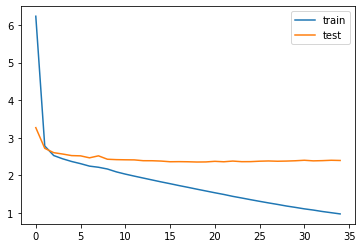

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

**INFERENCE** **MODEL**

In [ ]:
saved_model = tf.keras.models.load_model('./drive/MyDrive/en-hi.h5')

In [ ]:
vocab_size_source, Eword2index, englishTokenizer=pkl.load(open('/content/drive/MyDrive/Base_Etokenizer.pkl', 'rb'))

In [ ]:
vocab_size_target, Hword2index, hindiTokenizer=pkl.load(open('/content/drive/MyDrive/Base_Htokenizer.pkl', 'rb'))

In [ ]:
Eindex2word = englishTokenizer.index_word
Hindex2word = hindiTokenizer.index_word

In [ ]:
inputs = saved_model.get_layer('input_1').output
_,state_h,state_c = saved_model.get_layer('lstm').output
targets = saved_model.get_layer('input_2').output
embedding_layer = saved_model.get_layer('embedding_1')
decoder_lstm = saved_model.get_layer('lstm_1')
dense1 = saved_model.get_layer('dense')

In [ ]:
d_model=256
#Encoder
encoder = tf.keras.models.Model(inputs, [state_h, state_c])

#Decoder
decoder_input_h = tf.keras.layers.Input(shape=(d_model,))
decoder_input_c = tf.keras.layers.Input(shape=(d_model,))
x = embedding_layer(targets)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = dense1(x)
decoder = tf.keras.models.Model([targets]+[decoder_input_h, decoder_input_c],[x]+[decoder_output_h, decoder_output_c])

In [ ]:
def predict__sentence(en_input):
  input_seq = englishTokenizer.texts_to_sequences([en_input])

  next_h, next_c = encoder.predict(input_seq)

  curr_token = np.zeros((1,1))
  curr_token[0,0] = hindiTokenizer.word_index['<START>']

  pred_sentence = ''

  for i in range(10):
    output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c])
    next_token = np.argmax(output[0, 0, :])
    next_word = hindiTokenizer.index_word[next_token]
    if next_word == '<END>':
      break
    else:
      pred_sentence += ' ' + next_word
      curr_token[0] = next_token

  return pred_sentence

In [ ]:
print(predict__sentences('i love my country'))
print(predict__sentences("India is a beautiful country"))
print(predict__sentences("Students in my class are well disciplined"))
print(predict__sentences("how are you?"))
print(predict__sentences("I am a Graduate Sudent in Future"))
print(predict__sentences("I love studying computer language"))
print(predict__sentences("Sir or Mam please give your feedback"))

मैं अपने देश से प्यार करता हुँ
भारत एक सुंदर देश है
 स्थिति करते थे करें क्या है
क्या हाल है?
मैं भविष्य में एक स्नातक छात्र हूं
 किला बहुत क्षमता सोचता था
सर या मैम कृपया अपनी प्रतिक्रिया दें


In [ ]:
predict__sentences('i love my country')

'मुझे अपने देश से प्यार है'